# Porto Seguro's Safe Driver Prediction

##### About: Porto Seguro is one of Brazil’s largest auto and homeowner insurance companies. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones. 

###### What problem are you solving? 

Build a strong prediction model Porto Seguro will be able utilize in order to provide a fairer insurance cost for their customers based on the individual’s driving habits. 

###### Hypothesis: 
    
Correlated binary and categorical predictors will help us determine a strong predictive model. We will be able to determine success by Normalized Gini Coefficient. 

In [74]:
#General Imports

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
#Load in the dataset

train = pd.read_csv('/Users/mnavarrete/Desktop/train.csv')
test = pd.read_csv('/Users/mnavarrete/Desktop/test.csv')

### Quality check

train.head()

In [73]:
#We are given 56 anonymized features which we can use to model claims and make predictions.

#Based on the dataset description we know: 

#Variables that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc).

#Variables names include the postfix bin to indicate binary features and cat to indicate categorical features.

#Variables without these designations are either continuous or ordinal.

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [20]:
#Shape of dataset

train.shape

(595212, 59)

In [41]:
#Check if we have any null across columns

train.isnull().sum()

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


In [43]:
#Based on the description we know the dataset has filled the null data with -1 

#Identify where and how many -1 we have in the dataset

(train==-1).sum()

id                     0
target                 0
ps_ind_01              0
ps_ind_02_cat        216
ps_ind_03              0
ps_ind_04_cat         83
ps_ind_05_cat       5809
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03         107772
ps_car_01_cat        107
ps_car_02_cat          5
ps_car_03_cat     411231
ps_car_04_cat          0
ps_car_05_cat     266551
ps_car_06_cat          0
ps_car_07_cat      11489
ps_car_08_cat          0
ps_car_09_cat        569
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              5
ps_car_12              1
ps_car_13              0
ps_car_14          42620
ps_car_15              0
ps_calc_01             0


In [63]:
#Replace the -1 with NaN

train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

#To ensure NaN has been implemented we can run a boolean function that returns
#if there is Null across the dataset

train_copy.isnull().any().any()

True

(595212, 59)


0    573518
1     21694
Name: target, dtype: int64

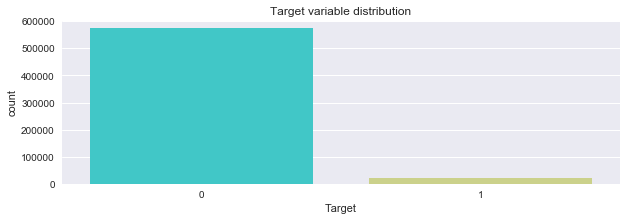

In [95]:
#Target Exploration

#The target variable is imbalanced. 

#Knowing this, we will try a few approaches to see how we can avoid overfitting the data. 

plt.figure(figsize=(10,3))
sns.countplot(train_copy['target'],palette='rainbow')
plt.xlabel('Target')
plt.title('Target variable distribution')

print train_copy.shape
train_copy['target'].value_counts()

In [96]:
##Now let's prepare lists of numeric, categorical and binary columns
# All features

all_features = train_copy.columns.tolist()
all_features.remove('target')

# Numeric Features
numeric_features = [x for x in all_features if x[-3:] not in ['bin', 'cat']]

# Categorical Features
categorical_features = [x for x in all_features if x[-3:]=='cat']

# Binary Features
binary_features = [x for x in all_features if x[-3:]=='bin']

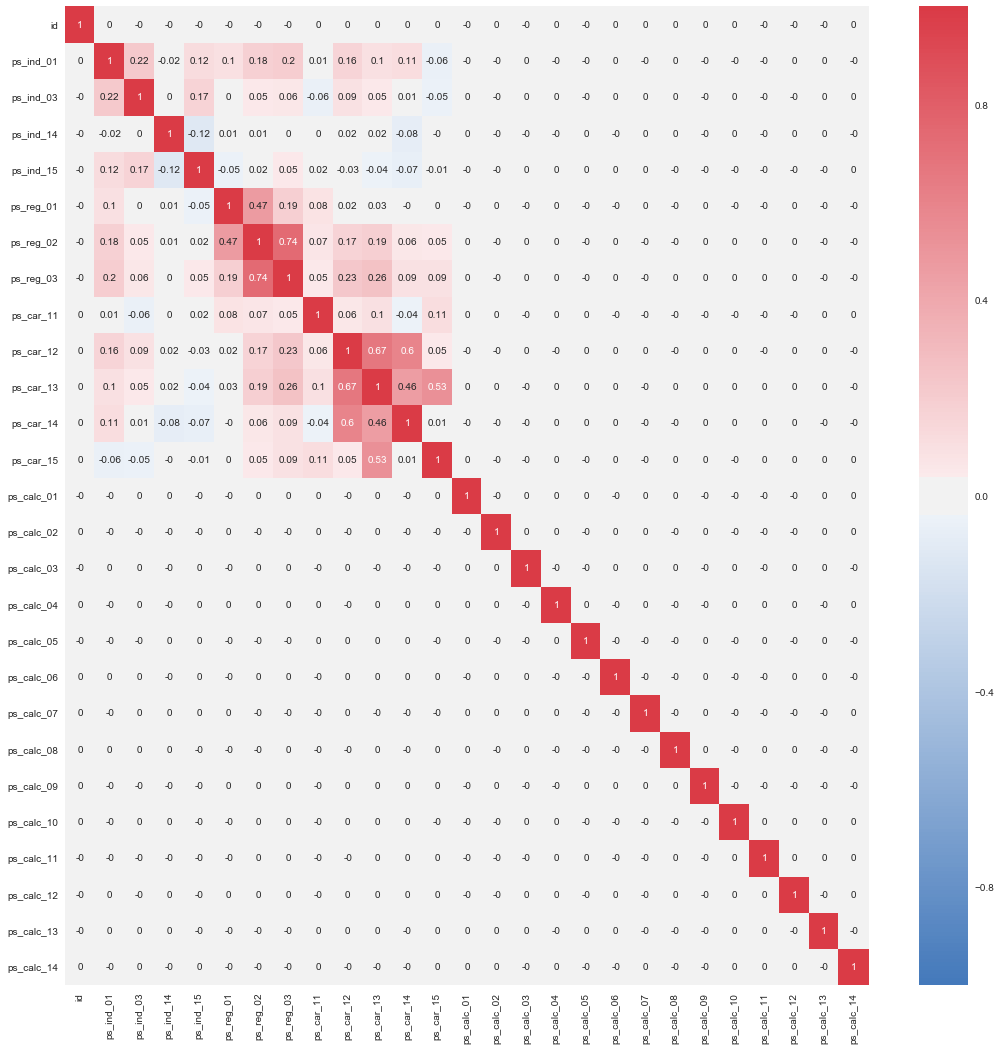

In [98]:
# Corralation between Variables using corralation matrix heatmap
# Getting correlation matrix
# The data obtained in correlation we can test for how much they can influence the dependant variable 'Target'

cor_matrix = train_copy[numeric_features].corr().round(2)

# Plotting heatmap 
fig = plt.figure(figsize=(18,18));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()